# Micrograd

For understanding backgropogation

Micrograd takes values and performs back propogation

In [80]:
import math
import random

from graphviz import Digraph

In [81]:
# visualize computation graph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [82]:
# data structure for keeping value and performing backprop
class Value:
    def __init__(self, data, _children: tuple = (), _op=''):
        '''
        self.data - value we want to store
        self._prev - children in backprop order (e.g. z = x + y then x and y are children of z)
        self._backward - calculates the gradient for its children
        self.grad - accumulated gradient dL/d(self) (derivative of final output w.r.t. this Value)
        self._op - operation performed to get current value (e.g. z._op="+" if z = x + y)
        '''
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0
        self._op = _op

    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __neg__(self):
        return self * -1
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # e.g. z = self + other
            self.grad += 1.0 * out.grad   # dL/d(self) += dL/dz * dz/d(self) = 1.0 * out.grad
            other.grad += 1.0 * out.grad  # dL/d(other) += dL/dz * dz/d(other) = 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # e.g. z = self * other
            self.grad += out.grad * other.data  # dL/d(self) += dL/dz * dz/d(self) = out.grad * other
            other.grad += out.grad * self.data  # dL/d(other) += dL/dz * dz/d(other) = out.grad * self

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return self**-1 * other

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad # Power Rule

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), f"exp")

        def _backward():
            self.grad += out.data * out.grad # derivative of e^x is itself

        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), f"tanh")

        def _backward():
            self.grad += (1-math.tanh(self.data)**2) * out.grad

        out._backward = _backward
        return out

    def relu(self):
        out = Value(max(self.data, 0), (self,), "ReLU")

        def _backward():
            self.grad += (self.data > 0) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo_order = []
        visited = set()
        def topo_sort(node):
            if node in visited:
                return
            visited.add(node)
            for child in node._prev:
                topo_sort(child)
            
            topo_order.append(node)
        
        topo_sort(self)
        topo_order = reversed(topo_order)

        self.grad = 1
        for node in topo_order:
            node._backward()

Value(0.9142310671899407)


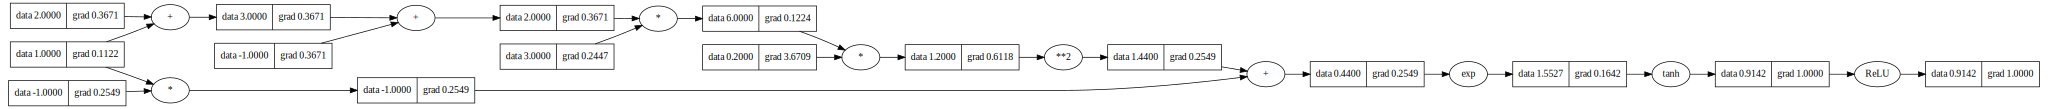

In [83]:
# test Value Implementation
x = Value(1.0)
y = ((3 * (2 + x - 1) / 5)**2 - x).exp().tanh().relu()
print(y)
y.backward()

draw_dot(y)

In [84]:
# Neuron in Neural Network
class Neuron:
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        assert len(self.weights) == len(x)
        out = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)]) + self.bias
        out = out.tanh()
        return out
    
    def parameters(self):
        return self.weights + [self.bias]
        

In [85]:
# Layer in Neural Network
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
        

In [86]:
# Multi-Layer Perceptron
class MLP:
    def __init__(self, nin, nouts: list):
        layer_size = [nin] + nouts
        self.layers = [Layer(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)]
    
    def __call__(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out  

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

In [87]:
# our MLP initialization
model = MLP(3, [4, 4, 1])

In [88]:
# data initialization
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [89]:
# training loop
epochs = 100

for epoch in range(1, epochs+1):

    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = 0

    # forward pass
    ypreds = [model(x) for x in xs]
    loss = sum((y-ypred)**2 for y, ypred in zip(ys, ypreds))

    # L2 Regularization
    alpha = 1e-4
    loss += alpha * sum((p**2) for p in model.parameters())

    # backward pass
    loss.backward()

    # update step
    lr = 0.1
    for param in model.parameters():
        param.data += -lr * param.grad
    
    print(f"Epoch {epoch}: Loss={loss.data}")

Epoch 1: Loss=1.828313922444759
Epoch 2: Loss=0.26037561207529436
Epoch 3: Loss=0.16593480642824296
Epoch 4: Loss=0.12080582483400802
Epoch 5: Loss=0.09447647529244309
Epoch 6: Loss=0.07733322590967871
Epoch 7: Loss=0.0653359746367919
Epoch 8: Loss=0.056497772921340644
Epoch 9: Loss=0.04973159423118516
Epoch 10: Loss=0.04439453607142014
Epoch 11: Loss=0.040082931846376416
Epoch 12: Loss=0.03653101075838769
Epoch 13: Loss=0.033556902743050794
Epoch 14: Loss=0.031032097418039462
Epoch 15: Loss=0.02886329838069778
Epoch 16: Loss=0.026981188188460833
Epoch 17: Loss=0.025333223555072518
Epoch 18: Loss=0.023878873040274397
Epoch 19: Loss=0.02258638505385997
Epoch 20: Loss=0.02143054293414421
Epoch 21: Loss=0.020391073231335717
Epoch 22: Loss=0.019451496212955745
Epoch 23: Loss=0.01859828191900516
Epoch 24: Loss=0.017820221243007597
Epoch 25: Loss=0.017107950867624414
Epoch 26: Loss=0.016453589960714058
Epoch 27: Loss=0.015850459182096988
Epoch 28: Loss=0.015292861083262905
Epoch 29: Loss=0.0

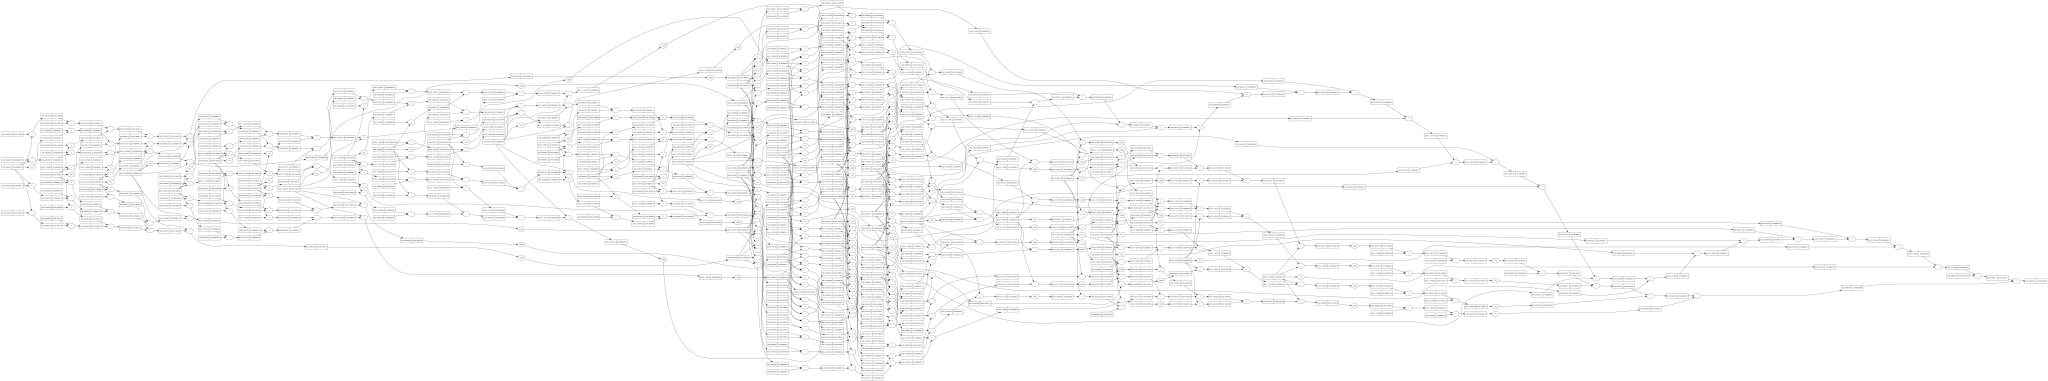

In [90]:
draw_dot(loss)

In [91]:
print([model(x) for x in xs])

[Value(0.9771286327030303), Value(-0.9675096073731755), Value(-0.9705846498070544), Value(0.9699967031726499)]
